# 範例重點
學習如何在 keras 中加入 EarlyStop <br />
知道如何設定監控目標 <br />
比較有無 earlystopping 對 validation 的影響

In [1]:
from keras.layers import Dense, Conv2D, Activation, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input
import keras
import matplotlib.pyplot as plt

!nvidia-smi

Using TensorFlow backend.


Sat Jul 20 01:01:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def preproc_x(x, flatten = True):
  x = x / 255.0
  if flatten :
    x = x.reshape((len(x), -1))
  return x

def preproc_y(y, num_classes = 10):
  
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y, num_classes)
  return y

In [0]:
train_x = preproc_x(train_x)
train_y = preproc_y(train_y)

test_x = preproc_x(test_x)
test_y = preproc_y(test_y)

In [0]:
def build_mlp(input_shape, output_units = 10, num_neurons = [512, 256, 128]):
  
  input_layer = Input(input_shape, name = "main_input")
  
  for i, n_neuron in enumerate(num_neurons):
    if i == 0 :
      x = Dense(units = n_neuron, name = "Hidden_layer_" + str(i+1))(input_layer)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
    else :
      x = Dense(units = n_neuron, name = "Hidden_layer_" + str(i+1))(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      
  output_layer = Dense(units = output_units, activation = 'softmax', name = "main_output") (x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = [output_layer])
  return model  

In [0]:
lr = 1e-3
momentum = 0.95
#Large batch size will overfit easily
batch_size = 1024
epochs = 50

In [0]:
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                                  patience = 5,
                                                                  verbose = 1)

In [15]:
model = build_mlp(train_x.shape[1:], 10)
optimizer = keras.optimizers.SGD(lr = lr, momentum = momentum)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

history = model.fit(train_x, train_y, epochs = epochs, batch_size = batch_size, shuffle = True, validation_data = [test_x, test_y],
                   callbacks = [early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
__________

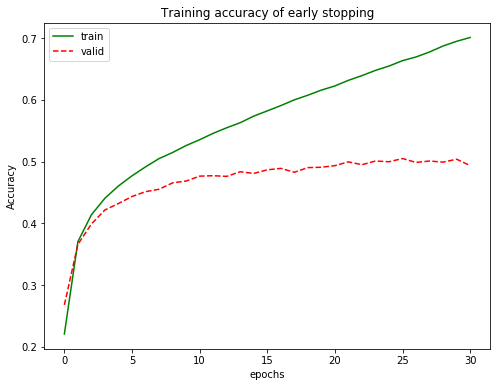

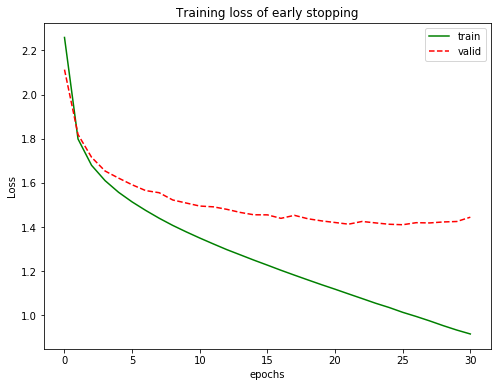

In [16]:
plt.figure(figsize = (8,6))
plt.plot(history.history['acc'],'-', label = "train", color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid', color = 'r')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("Training accuracy of early stopping")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['loss'],'-', label = "train", color = 'g')
plt.plot(history.history['val_loss'],'--', label = "valid", color = 'r')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Training loss of early stopping")
plt.legend()
plt.show()

# Work
試改變 monitor "Validation Accuracy" 並比較結果 <br />
調整 earlystop 的等待次數至 10, 25 並比較結果

In [18]:
patiences = [10, 25]

results = {}

for patience in patiences :
  early_stopping = keras.callbacks.EarlyStopping(monitor = "val_acc", patience = patience, verbose = 1)
  
  model = build_mlp(train_x.shape[1:], 10)
  optimizer = keras.optimizers.SGD(lr= lr, momentum = momentum)
  model.compile( optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
  
  history = model.fit(train_x, train_y, batch_size = batch_size, epochs = epochs, shuffle = True, 
                              validation_data = [test_x, test_y], callbacks = [early_stopping])
  
  
  name_tag = "EarlyStopping_" + str(patience)
  results[name_tag] = {
      "train_loss" : history.history['loss'],
      "valid_loss" : history.history['val_loss'],
      "train_acc" : history.history["acc"],
      "valid_acc" :history.history["val_acc"]
  }

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 59us/step - loss: 2.1856 - acc: 0.2273 - val_loss: 2.0433 - val_acc: 0.2929
Epoch 2/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.7898 - acc: 0.3741 - val_loss: 1.8183 - val_acc: 0.3653
Epoch 3/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.6673 - acc: 0.4196 - val_loss: 1.7194 - val_acc: 0.4023
Epoch 4/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.5945 - acc: 0.4459 - val_loss: 1.6732 - val_acc: 0.4174
Epoch 5/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.5391 - acc: 0.4655 - val_loss: 1.6249 - val_acc: 0.4338
Epoch 6/50
50000/50000 [==============================] - 2s 36us/step - loss: 1.4943 - acc: 0.4822 - val_loss: 1.5890 - val_acc: 0.4457
Epoch 7/50
50000/50000 [==============================] - 2s 35us/step - loss: 1.4553 - acc: 0.4951 - val_loss: 1.5766 - val_acc

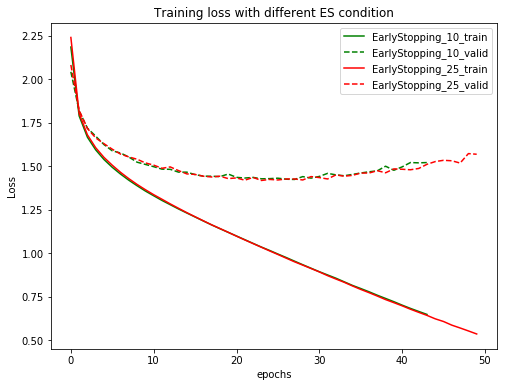

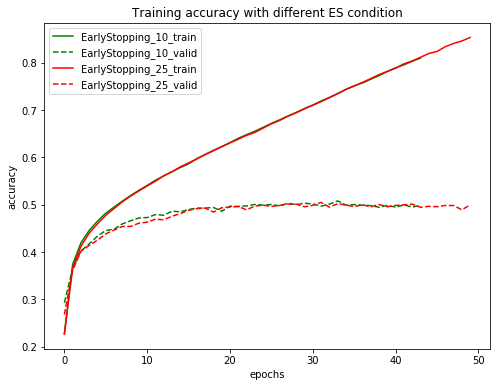

In [20]:
colors = ['g','r','b','y']
plt.figure(figsize = (8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_loss'], '-', label = cond + "_train", color = colors[i])
  plt.plot(results[cond]['valid_loss'], '--', label = cond + "_valid", color = colors[i])
  
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title("Training loss with different ES condition")
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
for i, cond in enumerate(results.keys()):
  plt.plot(results[cond]['train_acc'],'-', label = cond + "_train", color =  colors[i])
  plt.plot(results[cond]['valid_acc'],'--', label = cond + "_valid", color =  colors[i])
  
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title("Training accuracy with different ES condition")
plt.legend()
plt.show()